# Rede Neural Convolucional
## Classificação entre Gatos e Cachorros

### O dataset utilizado foi do Kaggle

In [1]:
import cv2
import pandas as pd
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [2]:
# reset dos graficos no tensorboard
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [15]:
# especificação das pastas
TRAIN_DIR = "cats_and_dogs/train"
TEST_DIR = "cats_and_dogs/test"

# tamanho para o qual a imagem será reduzida
IMG_SIZE = 50

# taxa de aprendizagem da rede
LR = 1e-3

# nome do modelo
MODEL_NAME = "dogs_vs_cats-{}-{}.model".format(LR, "6conv-basic")

In [4]:
# função para rotular através dos nomes dos arquivos

def label_img(img):
    word_label = img.split('.')[-3] # o nome do arquivo é, por ex., dog.42.jpg, queremos apenas o "dog"
    
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

In [5]:
# função para criar os dados de treino

def create_train_data():
    training_data = []
    
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        
        path = os.path.join(TRAIN_DIR, img)
        
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        training_data.append([np.array(img), np.array(label)])
        
    shuffle(training_data)
    
    np.save('train_data.npy', training_data)
    
    return training_data

In [6]:
# função para processar os dados de teste

def process_test_data():
    testing_data = []
    
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        
        img_num = img.split('.')[0]
        
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        
        testing_data.append([np.array(img), img_num])
        
    np.save('test_data.npy',testing_data)
    
    return testing_data

In [7]:
# train_data = create_train_data()

# if you already have train data:
train_data = np.load('train_data.npy', allow_pickle=True)

In [8]:
# arquitetura da rede neural convolucional

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
# amostragem dos dados de treino e teste

train = train_data[:-500]
test = train_data[-500:]

In [10]:
# dados de treino e teste

X_train = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = [i[1] for i in train]

X_test = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = [i[1] for i in test]

In [11]:
model.fit({'input': X_train}, {'targets': y_train}, n_epoch=5, validation_set=({'input': X_test}, {'targets': y_test}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1914  | total loss: 0.49664 | time: 34.173s
| Adam | epoch: 005 | loss: 0.49664 - acc: 0.7573 -- iter: 24448/24500
Training Step: 1915  | total loss: 0.49733 | time: 35.280s
| Adam | epoch: 005 | loss: 0.49733 - acc: 0.7581 | val_loss: 0.47268 - val_acc: 0.7780 -- iter: 24500/24500
--


#### O código abaixo deve ser rodado no anaconda prompt para ver os gráficos de acurácia e de validação no Tensorboard

tensorboard --logdir C:\Users\lucas\Documents\Programação\MachineLearning\DeepLearning\KaggleCatsVsDogs\log

In [16]:
import matplotlib.pyplot as plt

# if you don't have test data yet:
#test_data = process_test_data()

# if you already have:
test_data = np.load('test_data.npy')

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:11<00:00, 175.83it/s]
C:\Users\lucas\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


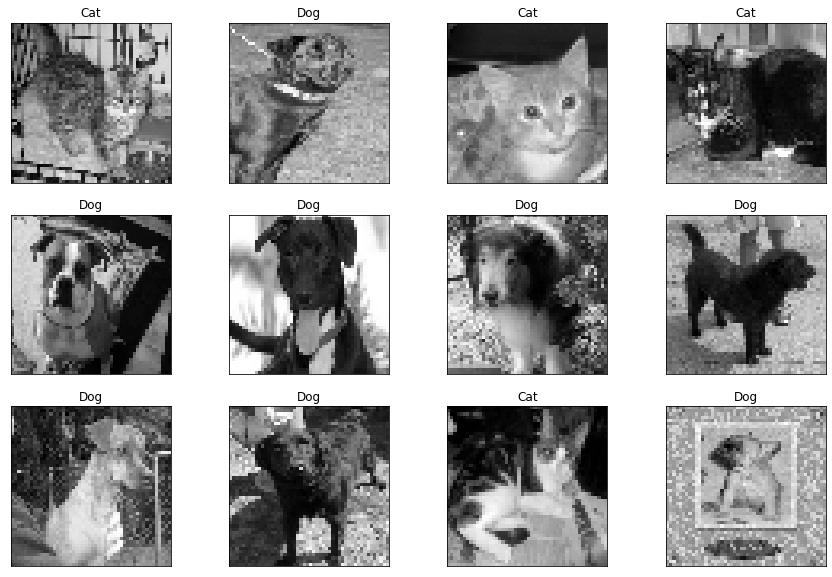

In [23]:
# predição de algumas imagens dos dados de teste carregado acima

fig = plt.figure(figsize=(15,10))

for num,data in enumerate(test_data[24:36]):
    # cat [1,0]
    # dog [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num+1)
    
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()